## *What is transfer learning?*
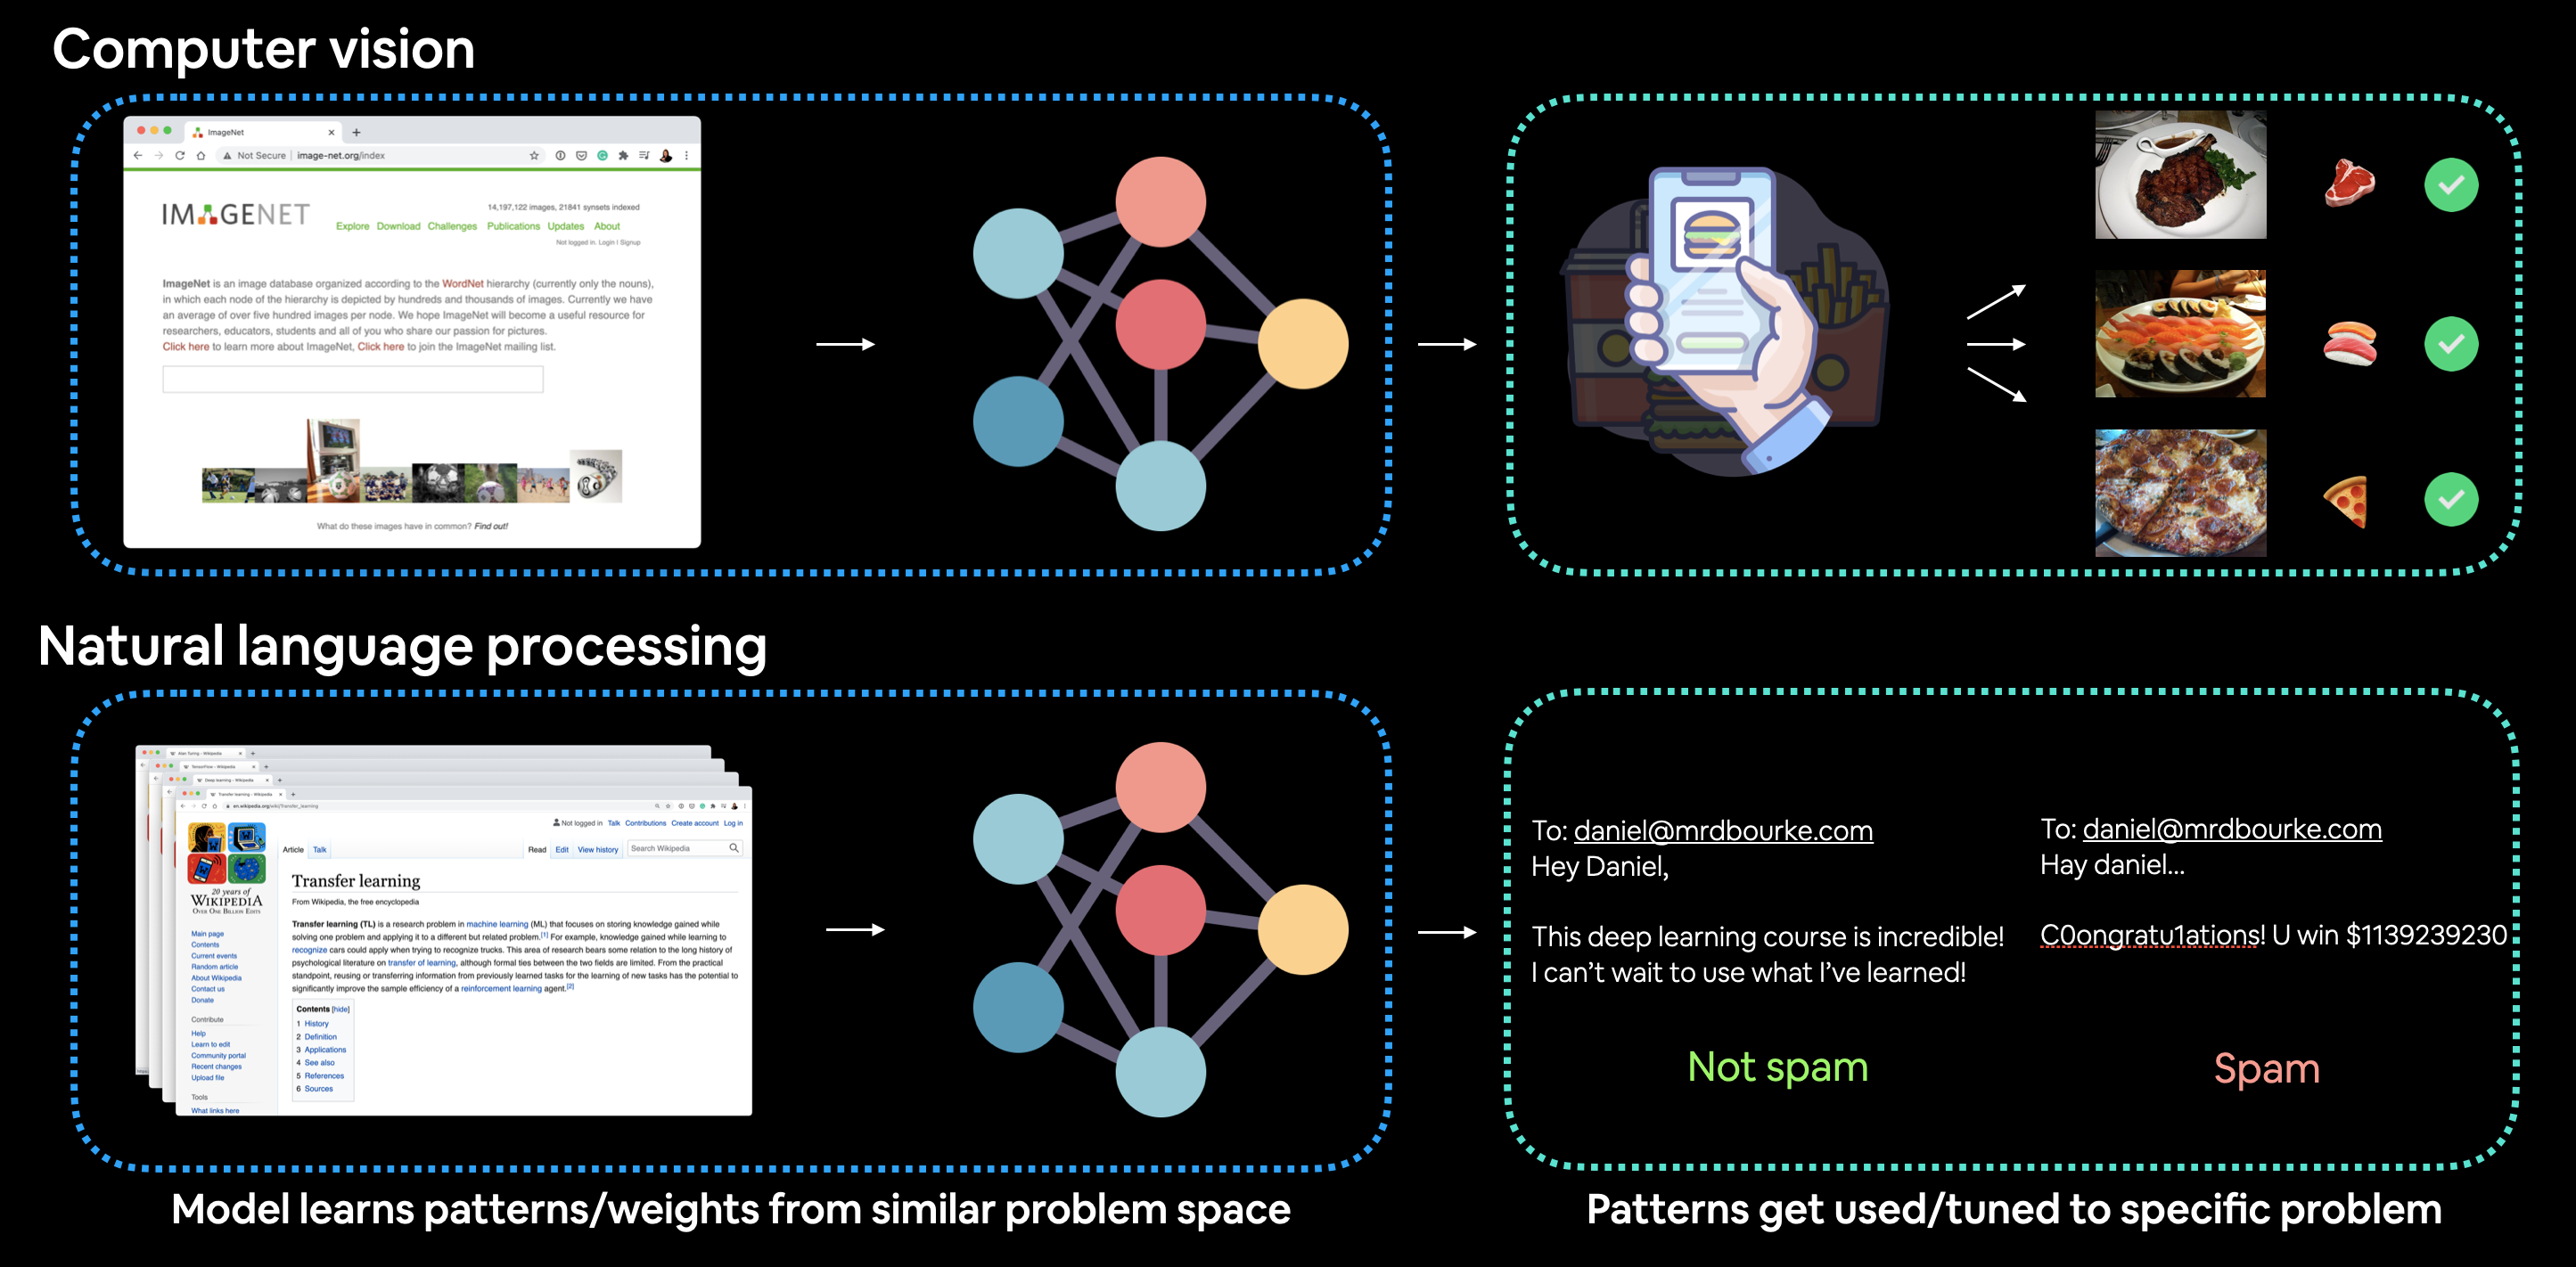

## *Why use transer learning?*
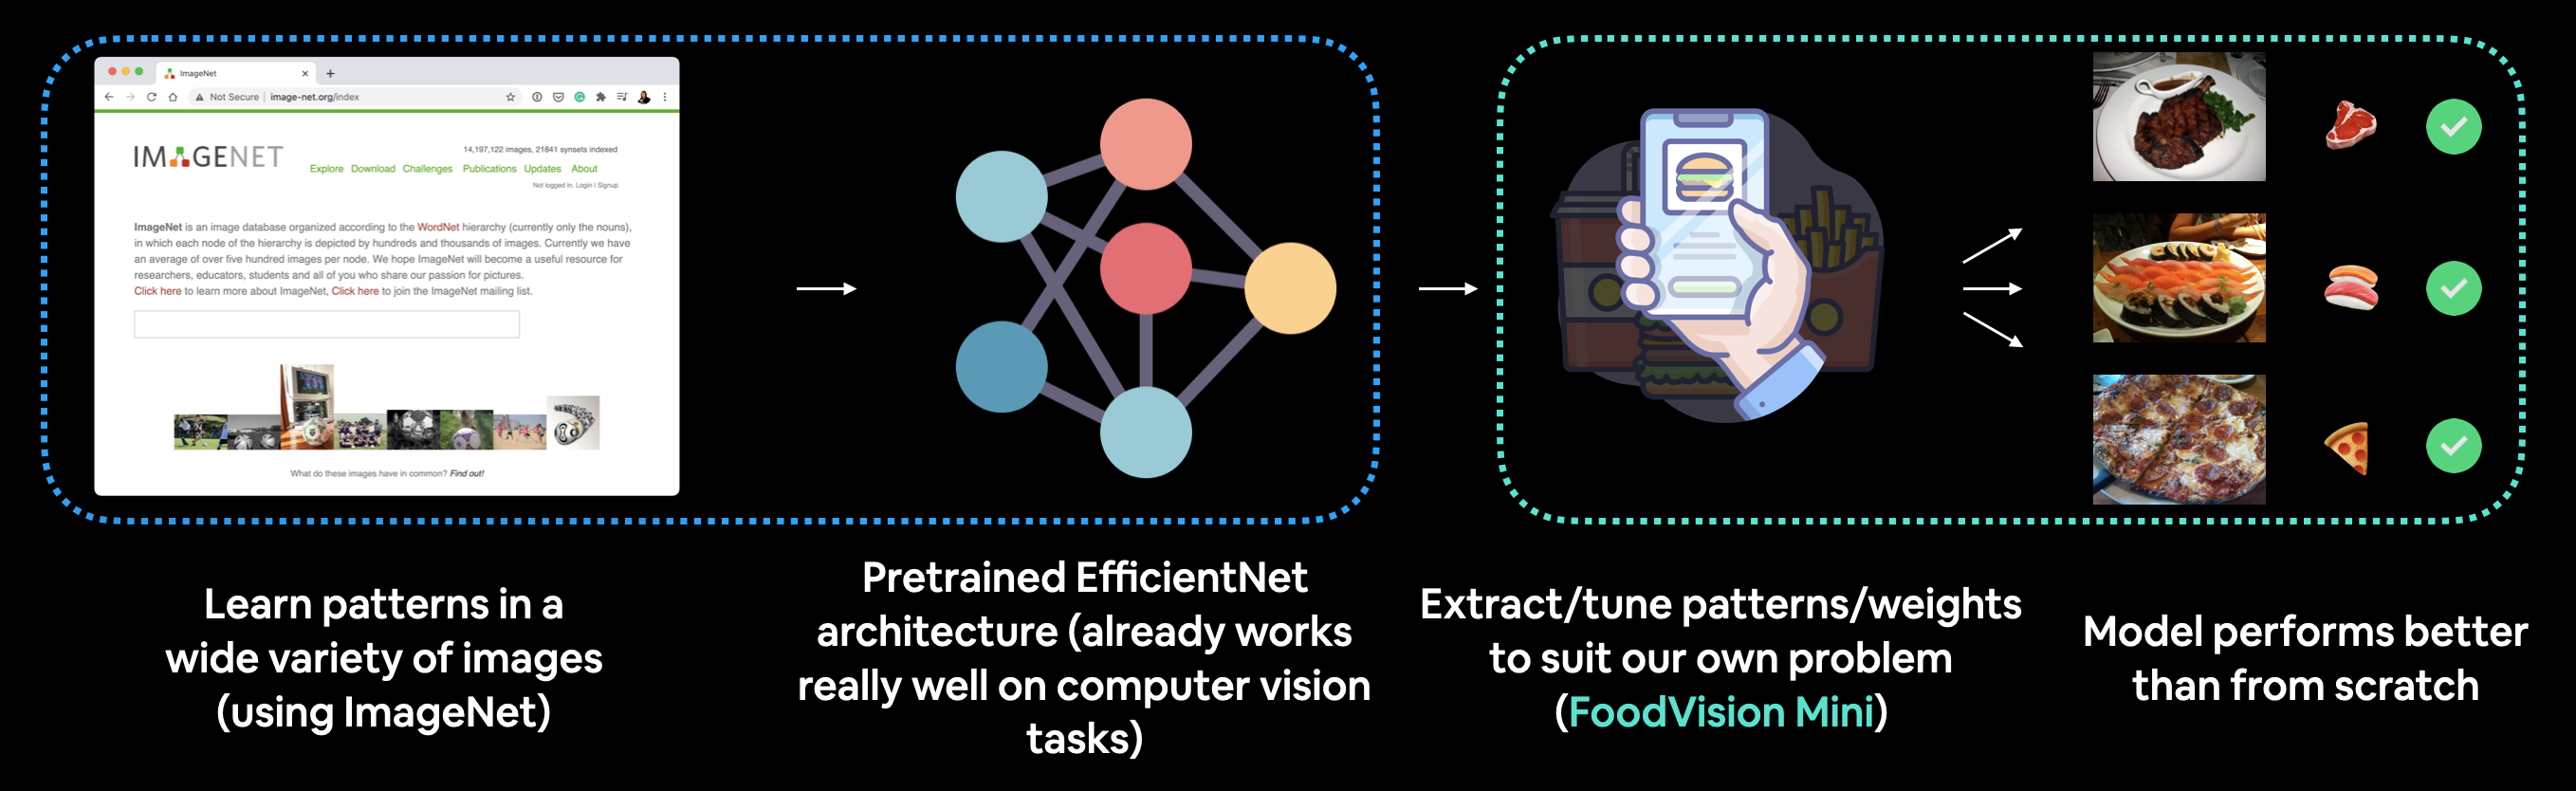

## *Where to find pretrained model?*
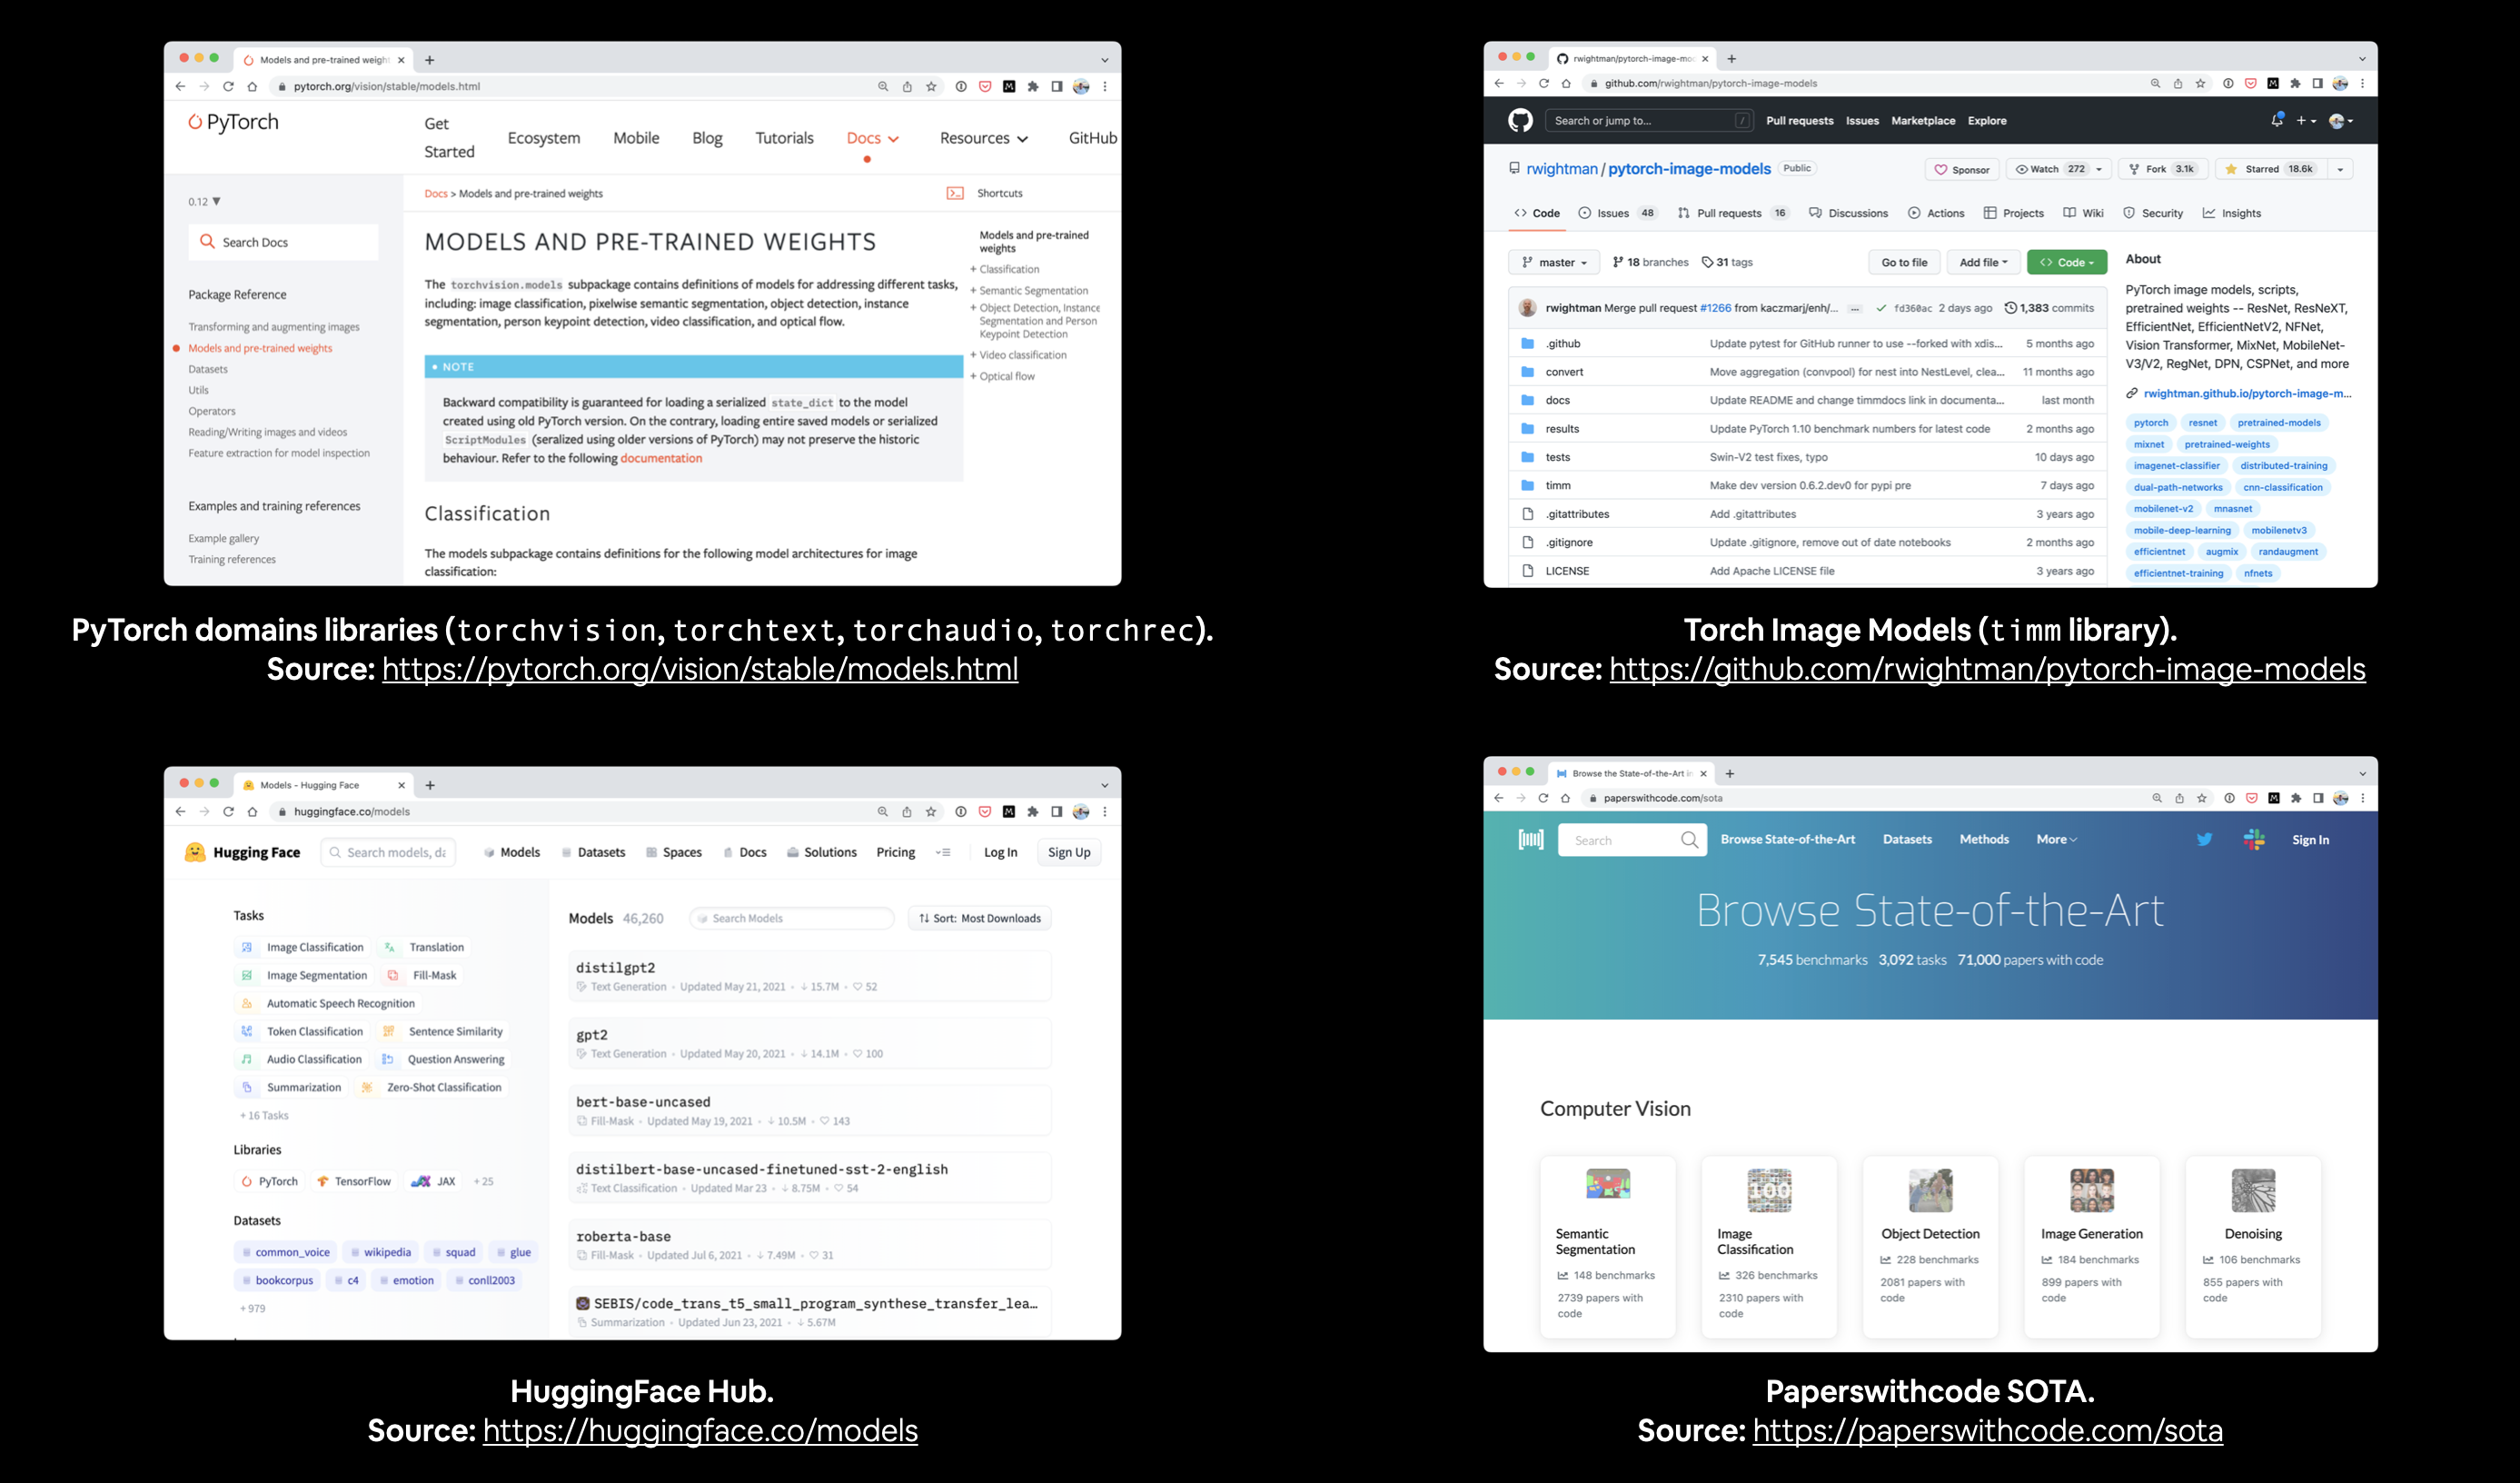

## *Getting setup*

In [ ]:
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12
  assert int(torchvision.__version__.split(".")[1]) >= 12
  print(f"torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")

except:
  print(f"[INFO] torch/ torchvision versions do not required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary

except:
  print("[INFO] couldn't find torchinfo.summary, install one...")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular.going_moduler import data_setup, engine

except:
  print("[INFO] couldn't find going_modular scripts... downloading them from Github.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

[INFO] couldn't find going_modular scripts... downloading them from Github.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3426, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 3426 (delta 52), reused 100 (delta 44), pack-reused 3302
Receiving objects: 100% (3426/3426), 643.48 MiB | 18.82 MiB/s, done.
Resolving deltas: 100% (1959/1959), done.
Updating files: 100% (222/222), done.
mv: cannot move 'pytorch-deep-learning/going_modular' to './going_modular': Directory not empty


In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## *Getting data*

In [ ]:
import os
import requests

from zipfile import ZipFile
from pathlib import Path

data_path= Path("data/")
image_path= data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists.")

else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents= True, exist_ok= True)

  with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
    request= requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza_steak_sushi data...")
    f.write(request.content)
  
  with ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

  os.remove(data_path/ "pizza_steak_sushi.zip")




data/pizza_steak_sushi directory already exists.


In [ ]:
train_dir= image_path/ "train"
test_dir= image_path/ "test"

## *Perform manual transform then create dataloaders*

In [ ]:
manual_transforms= transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229,0.224,0.225]) ])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
train_dataloader, test_dataloader, class_names= data_setup.create_dataloaders(train_dir= train_dir, test_dir= test_dir,transform= manual_transforms, batch_size= 32)
test_dataloader, train_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fe3a5383940>,
 ['pizza', 'steak', 'sushi'])

## *Create auto transforms with torchvision.models*

In [ ]:
weights= torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
train_dataloader, test_dataloader, class_names= data_setup.create_dataloaders(train_dir= train_dir, test_dir= test_dir,transform= auto_transforms, batch_size= 32)
test_dataloader, train_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fe3a537b9a0>,
 ['pizza', 'steak', 'sushi'])

## *Setting up a pretrained model*
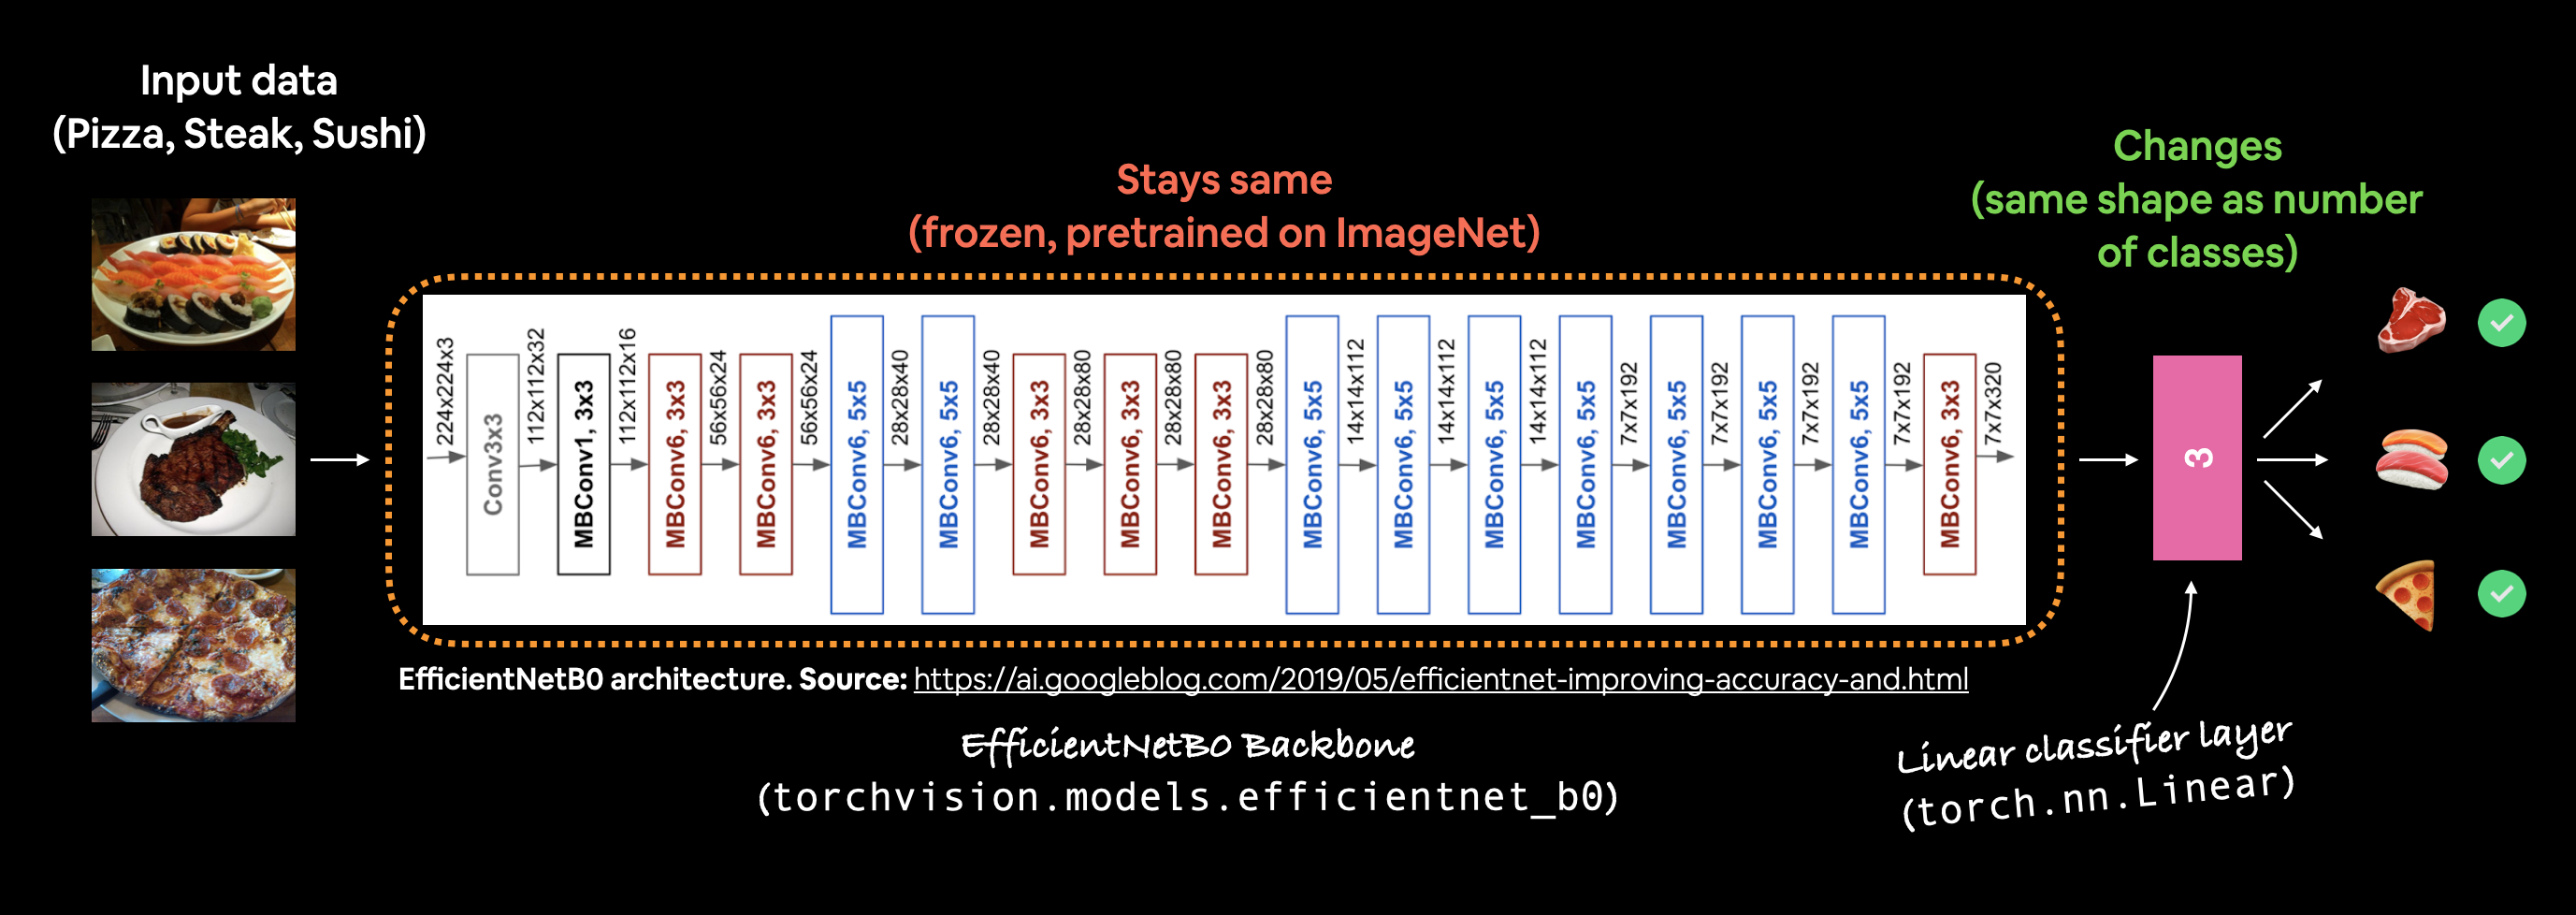

In [ ]:
weights= torchvision.models.EfficientNet_B0_Weights.DEFAULT
model= torchvision.models.efficientnet_b0(weights= weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

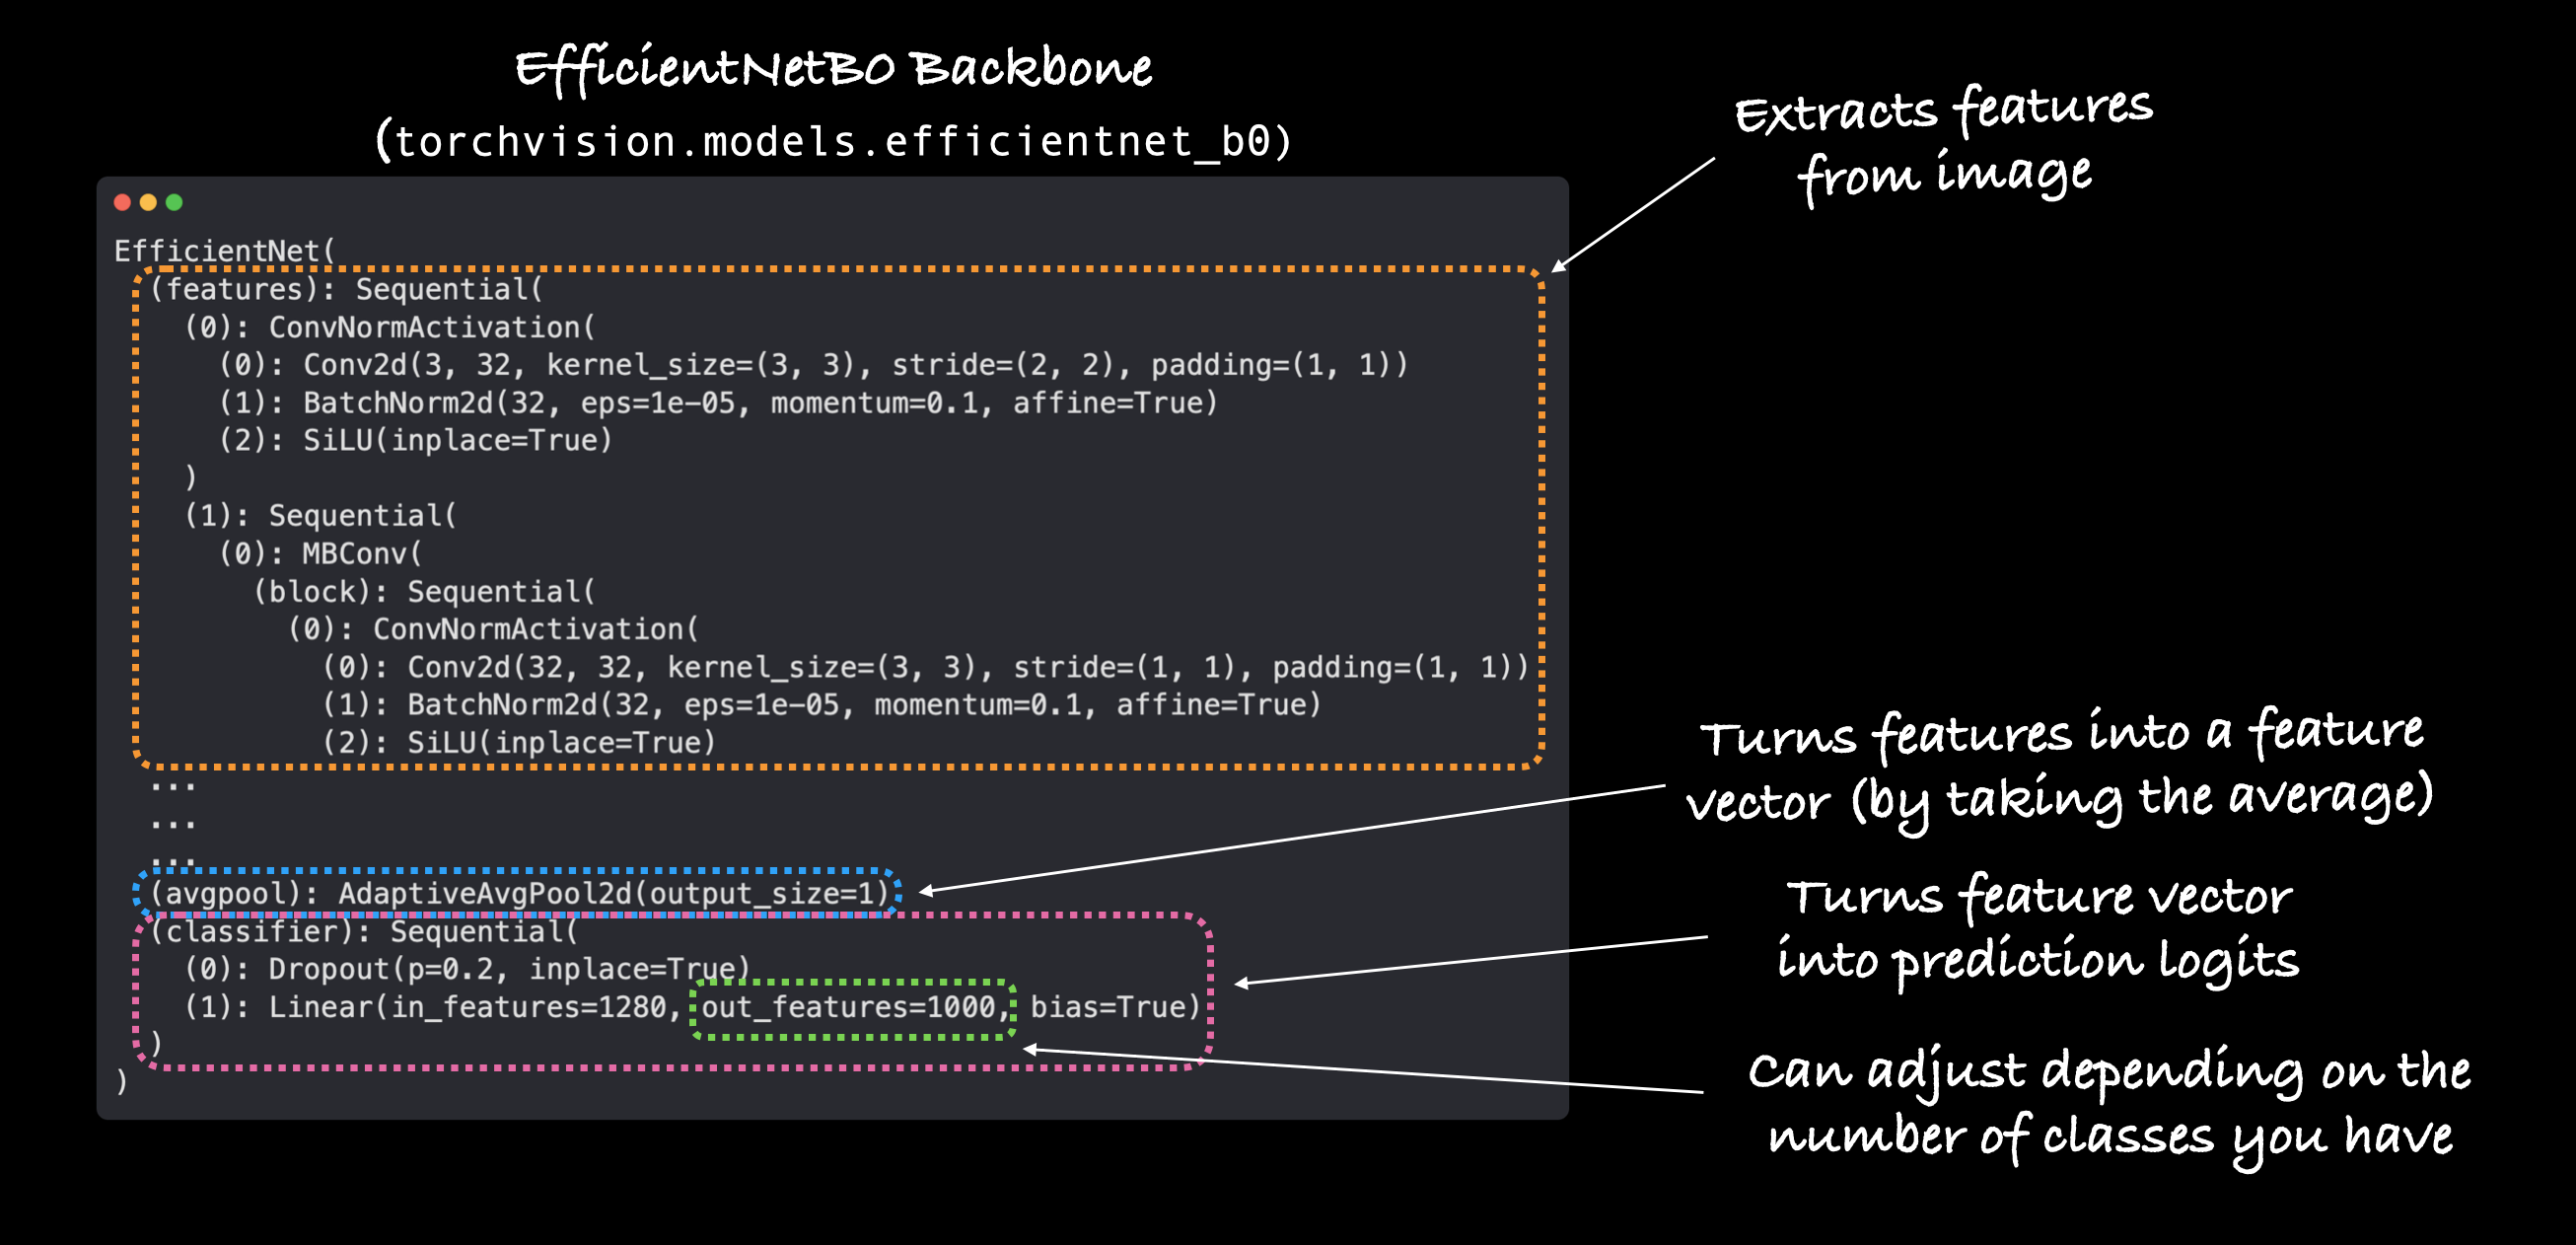

In [ ]:
summary(model= model, input_size= (32,3,224,224), col_names= ["input_size", "output_size", "num_params", "trainable"], col_width= 20,
        row_settings= ["var_names"]
        
        )


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

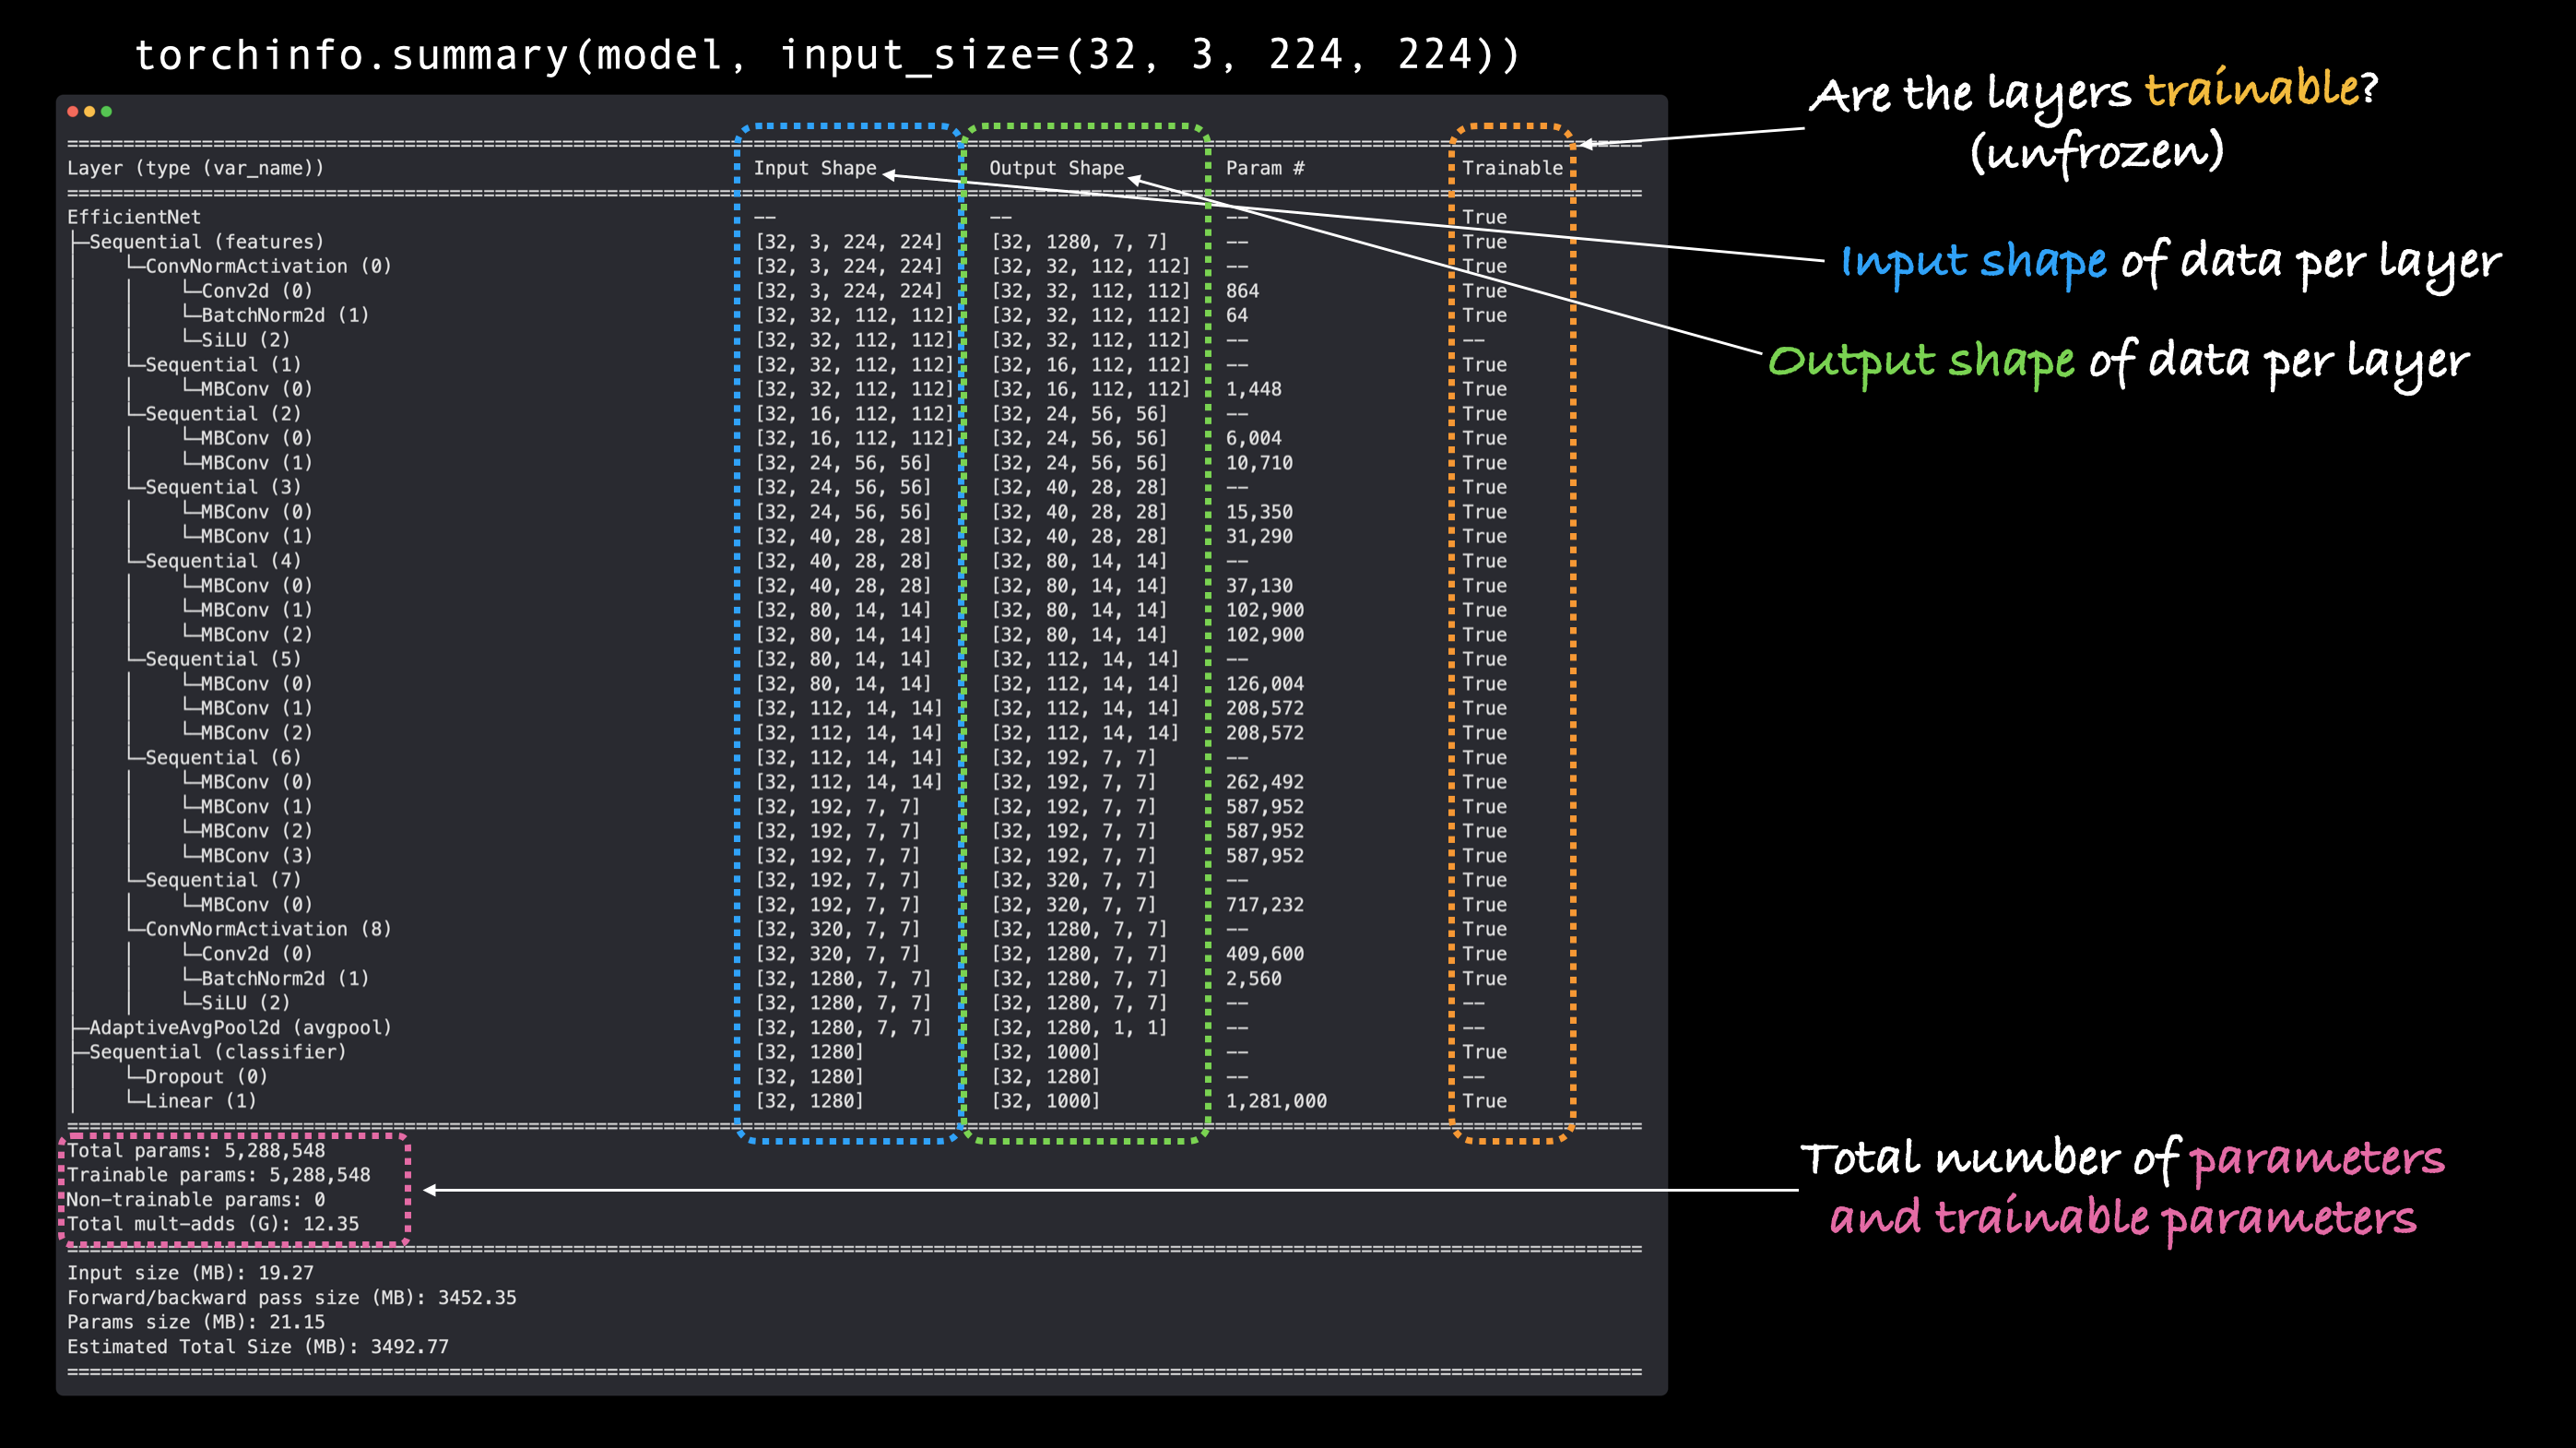

## *Freezing the base model and changing the output layer to suit our needs*
image.png


In [ ]:
for param in model.features.parameters():
  param.requires_grad= False

In [ ]:
model.classifier= nn.Sequential(
    
    nn.Dropout(0.2),
    nn.Linear(in_features= 1280, out_features= len(class_names))  

).to(device)

In [ ]:
summary(
    model= model, input_size= (32,3, 224,224), col_names= ["input_size","output_size", "num_params","trainable"], col_width= 20, row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

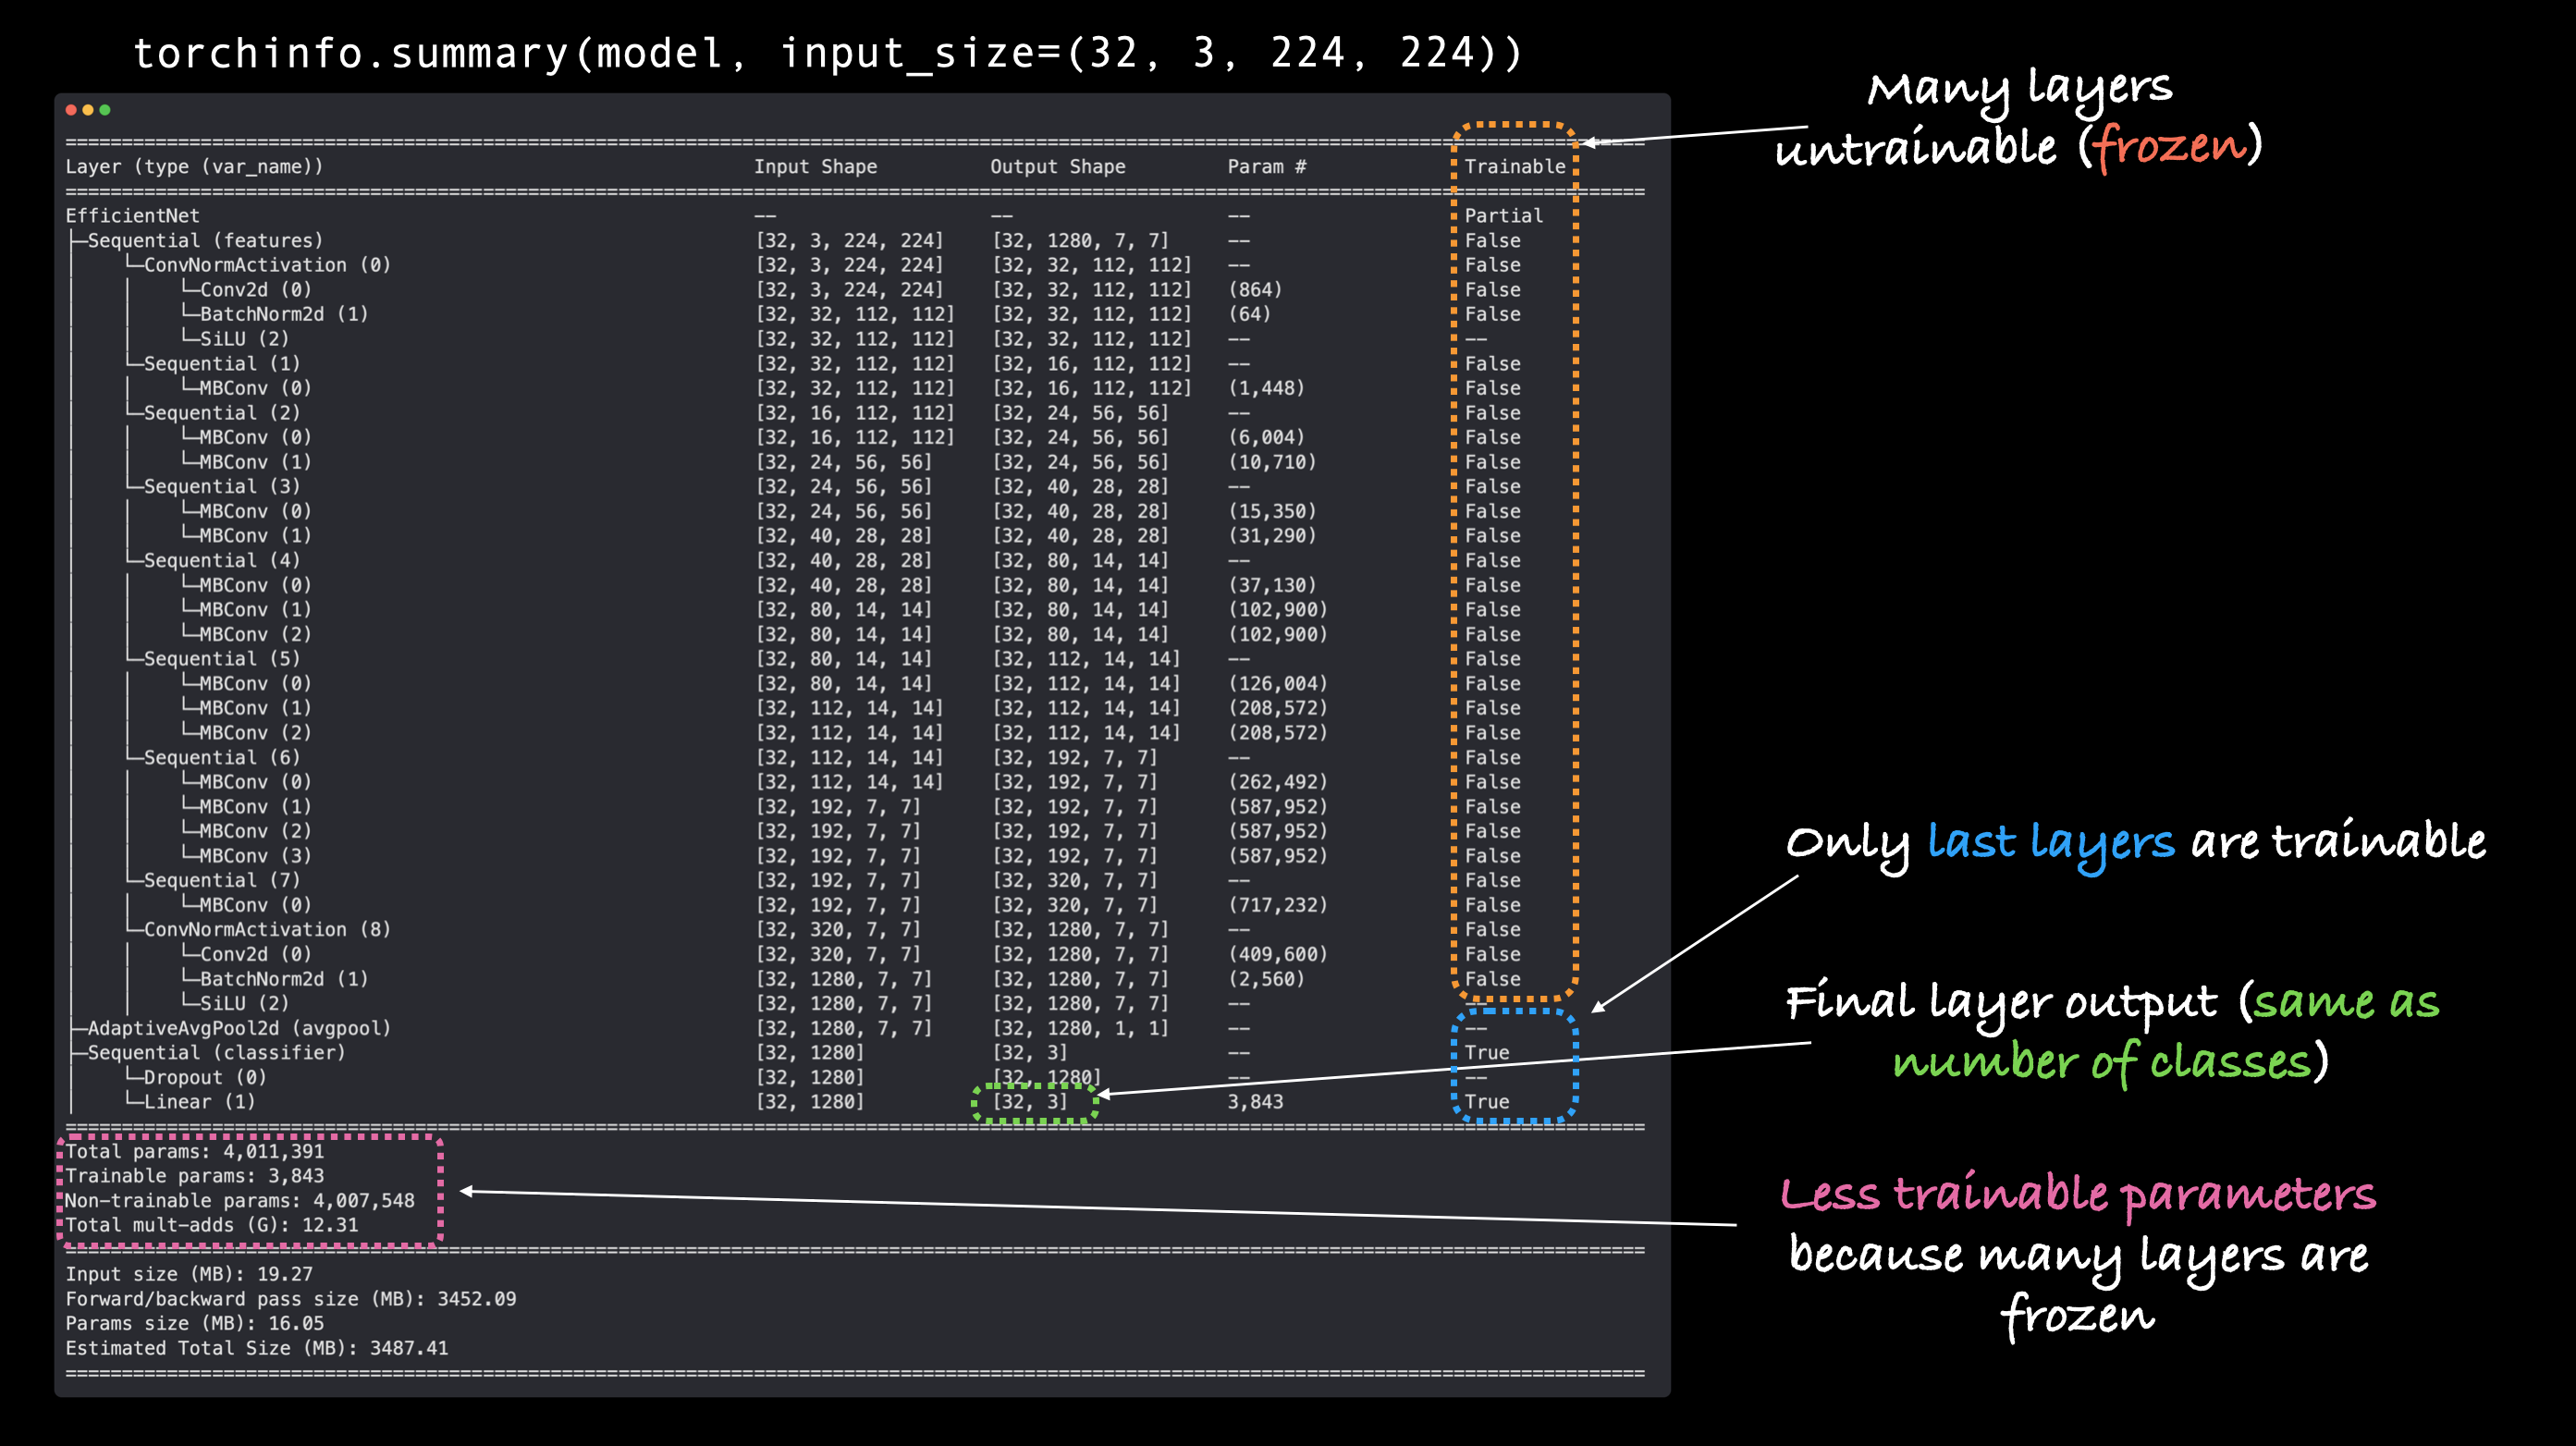

In [ ]:
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model.parameters(), lr= 0.001)

In [ ]:
from timeit import default_timer as timer
start_time= timer()

results= engine.train(model= model, train_dataloader= train_dataloader, test_dataloader= test_dataloader, optimizer= optimizer, loss_fn= loss_fn, epochs= 5, device= device)

end_time= timer()
print(f"[INFO] Training time:{end_time-start_time:.3f}")
print(results)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6096 | train_acc: 0.8008 | test_loss: 0.6148 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.4845 | train_acc: 0.9492 | test_loss: 0.5244 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5392 | train_acc: 0.8164 | test_loss: 0.5213 | test_acc: 0.8873
Epoch: 4 | train_loss: 0.4960 | train_acc: 0.8125 | test_loss: 0.4938 | test_acc: 0.8352
Epoch: 5 | train_loss: 0.5268 | train_acc: 0.8203 | test_loss: 0.5141 | test_acc: 0.8352
Training time:192.327
{'train_loss': [0.6096104942262173, 0.4845075011253357, 0.5391596257686615, 0.4959915243089199, 0.5268498510122299], 'train_acc': [0.80078125, 0.94921875, 0.81640625, 0.8125, 0.8203125], 'test_loss': [0.6147973338762919, 0.524375706911087, 0.5212774872779846, 0.49381495515505475, 0.5141252080599467], 'test_acc': [0.8664772727272728, 0.8873106060606061, 0.8873106060606061, 0.8352272727272728, 0.8352272727272728]}


## *Evaluate model by plotting loss curves*

In [ ]:
try:
  from helper_functions import plot_loss_curves
  print("helper_functions.py already exists.")

except:
  import requests
  print("[info] couldnot find helper_functions.py, downloading one..")
  with open("helper_functions.py", "wb") as f:

    request= requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
    from helper_functions import plot_loss_curves

helper_functions.py already exists.


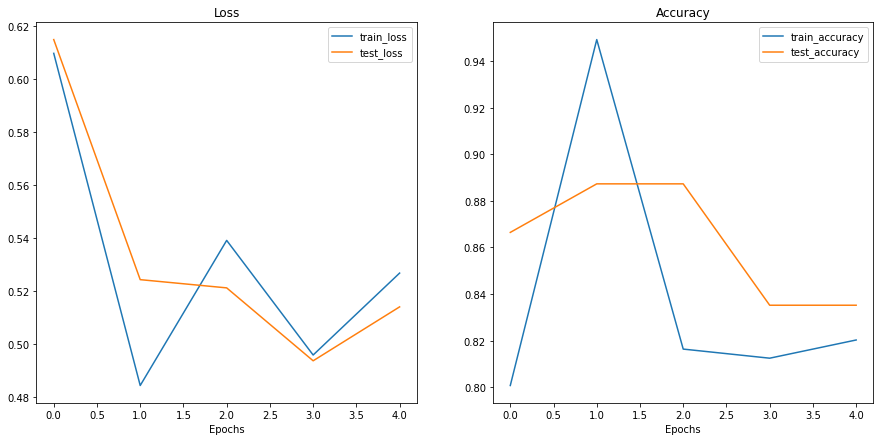

In [ ]:
plot_loss_curves(results)

## *Make predictions on images from the test set*

In [ ]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module, image_path: str, class_names: List[str], image_size= Tuple[int, int],
                        transform: torchvision.transforms= None, device:torch.device= device):
  
  img= Image.open(image_path)

  if transform is not None:
    image_transform= transform
  else:
    image_transform= transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                         transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])])
  
  model.to(device)
  model.eval()
  with torch.inference_mode():

    transformed_image= image_transform(img).unsqueeze(dim= 0)
    target_image_pred= model(transformed_image.to(device))
    target_image_pred_probs= torch.softmax(target_image_pred, dim= 1)
    target_image_pred_label= torch.argmax(target_image_pred_probs, dim= 1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred:{class_names[target_image_pred_label]}| Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)



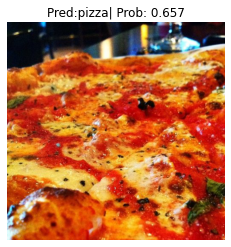

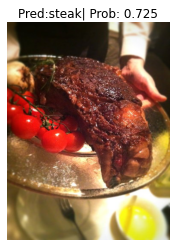

In [ ]:
import random
no_images= 3
test_image_path_list= list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample= random.sample(test_image_path_list, k= no_images)

for image_path in test_image_path_sample:

  pred_and_plot_image(model= model, image_path= image_path, class_names= class_names, image_size= ((224,224)))



## *Making predictions on a custom image*

data/pizza_dad.jpeg already exists, skipping download..


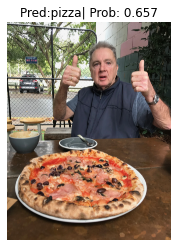

In [ ]:
import requests

custom_image_path= data_path/ "pizza_dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request= requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    f.write(request.content)

else:
  print(f"{custom_image_path} already exists, skipping download..")

pred_and_plot_image(model= model, image_path= custom_image_path, class_names= class_names, image_size=(224,224))
